# Carbon Flow Tracing Tutorial

In this tutorial, we will:
- Model a simple power system with generators, buses, and transmission lines.
- Solve an optimal power flow (OPF) problem using CVXPY.
- Compute generator contributions to loads.
- Estimate carbon emissions at different buses.

**Note:** Make sure to install `cvxpy` before running.






## 1. Import required libraries

In [1]:
import numpy as np
import cvxpy as cp
import random
import csv
import sys
from datetime import datetime
import time

# Set seed for reproducibility
np.random.seed(29)

## 2. Spanning tree to identify reachable sets for each generator.

We firstly define the function recuse_son for traversing the network graph. 

We show an example using depth first tree search to traverse all children nodes.

In [9]:
# Replace the previous find_child and recurse_son with these corrected versions.

def find_child(directed_graph, current_vertex):
    """
    Return lists:
      - sons: list of child bus indices (ints)
      - line_idx: list of corresponding line indices (ints)

    A directed_graph is the incidence matrix (num_lines x num_buses) with entries -1 (from),
    +1 (to), 0 otherwise. A line is considered a child-edge of current_vertex if that
    line has -1 at current_vertex (meaning flow goes out from current_vertex along that line).
    """
    sons = []
    line_idx = []
    for i in range(num_lines):
        # if the line leaves the current vertex
        if directed_graph[i][current_vertex] == -1:
            # find the bus that this line goes into (where value == 1)
            idx = np.where(directed_graph[i, :] == 1)[0]
            if idx.size > 0:
                sons.append(int(idx[0]))   # make it a plain Python int
                line_idx.append(int(i))
    return sons, line_idx


def recurse_son(father, Spanning_tree, ratio_now, visited, gen_line_prop_mat):
    """
    Recursively propagate contribution ratios from a generator 'father' node down the directed graph.
    - father: int index of current node
    - Spanning_tree: (num_buses x 1) array accumulating contributions from this generator
    - ratio_now: scalar current ratio being propagated
    - visited: boolean 1D array marking visited buses
    - gen_line_prop_mat: (num_lines x num_buses) matrix storing line->bus ratios for this generator
    """
    node_current = int(father)
    visited[node_current] = True

    child_bus, child_connected_line = find_child(A_mat_directed, node_current)

    # If no children, nothing to propagate
    if not child_bus:
        return

    father_ratio = float(ratio_now)

    # iterate over children (plain python lists, so safe to index & use in visited)
    for k, current_son in enumerate(child_bus):
        current_son = int(current_son)
        line_i = int(child_connected_line[k])

        # compute new ratio along this line -> son
        new_ratio = line_prop_mat[line_i, node_current] * father_ratio

        # store contributions
        gen_line_prop_mat[line_i, current_son] = new_ratio
        Spanning_tree[current_son] += bus_prop_vec[current_son] * new_ratio

        # only recurse if not visited (prevents infinite loops)
        if not visited[current_son]:
            recurse_son(current_son, Spanning_tree, new_ratio, visited, gen_line_prop_mat)

    return


## 3. Load system topology
The topology is stored in a CSV file ("30bus_topology.csv").
    
Each row represents a transmission line: (from_bus, to_bus).

In [10]:
np.set_printoptions(threshold=sys.maxsize)

num_gen = 6
num_buses = 30
num_lines = 41

with open("30bus_topology.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    rows = [row for row in reader]
    connection_all = np.array(rows[1:], dtype=float)

# Incidence matrix (lines x buses)
A_mat = np.zeros((num_lines, num_buses), dtype=float)
for i in range(num_lines):
    A_mat[i][int(connection_all[i][0]) - 1] = -1.0
    A_mat[i][int(connection_all[i][1]) - 1] = 1.0

## 4. Define generation costs, limits, and emissions

In [11]:
carbon_emissions = np.array([3.0, 2.7, 2.0, 1.5, 1.0, 1.8])  # tons CO2/MWh
Gen_node = np.array([0, 1, 12, 21, 22, 26])  # generator locations
C = np.array([1.0, 1.5, 2.4, 3.5, 5.0, 3.0])  # cost coefficients

# Generation limits
D1 = np.diag(np.full(6, 1))
D = np.stack((D1, -D1), axis=0)
D = np.reshape(D, (12, 6))
e = np.array([10.0, 15.0, 15.0, 15.0, 15.0, 15.0,   # upper limits
              -0.0, -0.0, -0.0, -0.0, -0.0, -0.0])  # lower limits

# Generator-bus incidence
b = np.zeros((30, 6), dtype=float)
for i, g in enumerate(Gen_node):
    b[g][i] = 1.0

## 5. Define decision variables and OPF formulation
Decision variables:
- x: generation output
- line_flow: power flows on transmission lines

In [12]:
x = cp.Variable(num_gen)
line_flow = cp.Variable(num_lines)

# Random load at each bus
load = np.random.uniform(0.2, 1.8, (num_buses, 1))
load = np.round(load, 2)

# Transmission line flow limits
line_flow_limit = np.ones((1, num_lines), dtype=float) * 4.0
neg_line_flow_limit = -line_flow_limit

## 6. Define optimization problem (linear DCOPF)

In [13]:
cost = cp.sum(C @ x)
constraints = [
    b @ x + A_mat.T @ line_flow == load.reshape(-1,),   # Power balance
    D @ x <= e,                                         # Generator limits
    line_flow <= line_flow_limit.reshape(-1,),          # Line upper limits
    line_flow >= neg_line_flow_limit.reshape(-1,)       # Line lower limits
]

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve()

print("Load (MW):", load.T)
print("Optimal Generation (MW):", np.round(x.value, 2))
print("Line flows (MW):", np.round(line_flow.value, 3))

Load (MW): [[0.41 1.23 0.97 1.25 0.33 1.26 0.99 1.41 0.88 0.73 0.96 1.67 0.69 1.78
  0.38 1.75 1.6  1.72 0.58 1.57 1.49 0.46 0.67 1.11 1.61 0.26 0.78 1.25
  1.39 1.74]]
Optimal Generation (MW): [ 8.41  9.23  4.69  0.    0.   10.59]
Line flows (MW): [ 4.     4.     4.     3.03   4.     4.     1.966  3.67  -2.68   0.43
  3.796  3.783  0.96   1.956  3.814 -4.     2.016  2.014  2.114  0.236
  0.364  1.753  0.033 -0.547  2.117  1.236  1.046  0.611 -0.444  0.116
 -0.293 -0.554 -1.957  0.26  -3.827 -2.853  1.515  1.615  0.125 -0.98
 -0.623]


## 7. Construct directed incidence matrix based on flow direction

In [14]:


A_mat_directed = np.copy(A_mat)
for i in range(num_lines):
    if line_flow.value[i] < 0:
        # Reverse the direction if flow is negative
        A_mat_directed[i][int(connection_all[i][0]) - 1] = 1.0
        A_mat_directed[i][int(connection_all[i][1]) - 1] = -1.0

print("Directed graph (incidence matrix):")
print(A_mat_directed)

Directed graph (incidence matrix):
[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0

In [15]:
# ## 8. Compute proportion matrices for power allocation

total_injection = np.dot(b, x.value)
line_prop_mat = np.zeros((num_lines, num_buses), dtype=float)
bus_prop_vec = np.zeros((num_buses, 1), dtype=float)

for i in range(num_buses):
    total_power = np.copy(load[i])
    total_inflow = 0.0
    for j in range(num_lines):
        if A_mat_directed[j][i] == -1:
            total_power += np.abs(line_flow.value[j])
        elif A_mat_directed[j][i] == 1:
            total_inflow += np.abs(line_flow.value[j])

    bus_prop_vec[i] = load[i] / total_power
    for j in range(num_lines):
        if A_mat_directed[j][i] == -1:
            line_prop_mat[j, i] = np.abs(line_flow.value[j]) / total_power

print("Bus proportion vector:", bus_prop_vec.T)
print("Line proportion matrix:\n", line_prop_mat)

Bus proportion vector: [[0.04875149 0.09297052 0.2425     0.17780939 0.0825     0.13592894
  0.26975477 1.         0.23181488 0.12718738 1.         0.21372845
  0.14712154 0.88289691 0.16891289 0.82782522 1.         0.98093475
  1.         0.74176601 1.         0.5085808  1.         0.56725735
  0.42071883 1.         0.07365439 0.4381021  0.91741774 1.        ]]
Line proportion matrix:
 [[0.47562426 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.47562426 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.  

/var/folders/sx/s8qpxybj18scnhbhptt1hhl80000gn/T/ipykernel_24892/2582280245.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line_prop_mat[j, i] = np.abs(line_flow.value[j]) / total_power


## 9. Compute generator contributions to loads

In [16]:


Gen_prop_mat = np.zeros((num_gen, num_lines, num_buses), dtype=float)
Gen_spanning_tree_all = np.zeros((num_buses, num_gen))

for i in range(num_gen):
    print("Generator", Gen_node[i], "with output", x.value[i])
    Gen_spanning_tree = np.zeros((num_buses, 1), dtype=float)
    current_Gen_prop_mat = np.zeros((num_lines, num_buses), dtype=float)
    visited = np.zeros(num_buses, dtype=bool)

    current_ratio = 1.0
    current_node = Gen_node[i]
    Gen_spanning_tree[current_node] = bus_prop_vec[current_node] * current_ratio

    recurse_son(current_node, Gen_spanning_tree, current_ratio, visited, current_Gen_prop_mat)

    print("Contribution to loads:", np.round(Gen_spanning_tree, 3).T)
    Gen_prop_mat[i] = current_Gen_prop_mat
    Gen_spanning_tree_all[:, i] = Gen_spanning_tree.reshape(-1,)

Generator 0 with output 8.409999999836584
Contribution to loads: [[0.049 0.044 0.115 0.09  0.012 0.038 0.036 0.002 0.004 0.003 0.004 0.017
  0.    0.018 0.004 0.017 0.005 0.002 0.001 0.002 0.002 0.    0.    0.
  0.    0.    0.    0.    0.    0.   ]]
Generator 1 with output 9.23000000003215
Contribution to loads: [[0.    0.093 0.    0.054 0.025 0.08  0.075 0.004 0.008 0.007 0.009 0.035
  0.    0.037 0.008 0.037 0.011 0.004 0.002 0.005 0.004 0.001 0.    0.
  0.    0.    0.    0.    0.    0.   ]]
Generator 12 with output 4.689999999891262
Contribution to loads: [[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.182
  0.147 0.194 0.041 0.191 0.04  0.02  0.    0.    0.    0.    0.001 0.
  0.    0.    0.    0.    0.    0.   ]]
Generator 21 with output 4.5799662444902423e-10
Contribution to loads: [[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.491 0.509 0.    0.
  0.    0.    0.    0.    0.    0.   

## 10. Compute load recovery and carbon emissions

In [17]:


load_vec = np.zeros((num_buses, 1), dtype=float)
carbon_vec = np.zeros((num_buses, 1), dtype=float)

for i in range(num_buses):
    for j in range(num_gen):
        load_vec[i] += Gen_spanning_tree_all[i, j] * x.value[j]
        carbon_vec[i] += Gen_spanning_tree_all[i, j] * x.value[j] * carbon_emissions[j]

print("Recovered Load vector:", load_vec.T)
print("Original Load vector:", load.T)
print("Carbon emissions vector:", carbon_vec.T)

average_emission_rate = carbon_vec / load_vec
print("Average emission rate at each bus (tons CO2/MWh):", average_emission_rate.T)

Recovered Load vector: [[0.41       1.23       0.97       1.25       0.33       1.14479817
  0.99       1.0608217  0.16537912 0.1371895  0.18041358 1.31868974
  0.69       1.40554954 0.30006114 1.38186051 0.36657274 0.14253193
  0.03777792 0.10055811 0.22332868 0.16894918 0.56338267 1.11
  1.61       0.26       0.78       1.25       1.39       1.74      ]]
Original Load vector: [[0.41 1.23 0.97 1.25 0.33 1.26 0.99 1.41 0.88 0.73 0.96 1.67 0.69 1.78
  0.38 1.75 1.6  1.72 0.58 1.57 1.49 0.46 0.67 1.11 1.61 0.26 0.78 1.25
  1.39 1.74]]
Carbon emissions vector: [[1.23       3.43256463 2.91       3.60114008 0.92093197 3.11086799
  2.76279592 1.96089572 0.40291066 0.3342327  0.4395389  3.00408847
  1.38       3.20196256 0.68356504 3.1479969  0.84760835 0.32469998
  0.09159954 0.24498821 0.45684625 0.31678169 1.01869439 1.998
  2.898      0.468      1.404      2.25       2.502      3.132     ]]
Average emission rate at each bus (tons CO2/MWh): [[3.         2.79070295 3.         2.88091206 2.7

## 11. Visualization of results
We will plot:
1. Generator values 

2. Bus demand values

3. Nodal emission rates



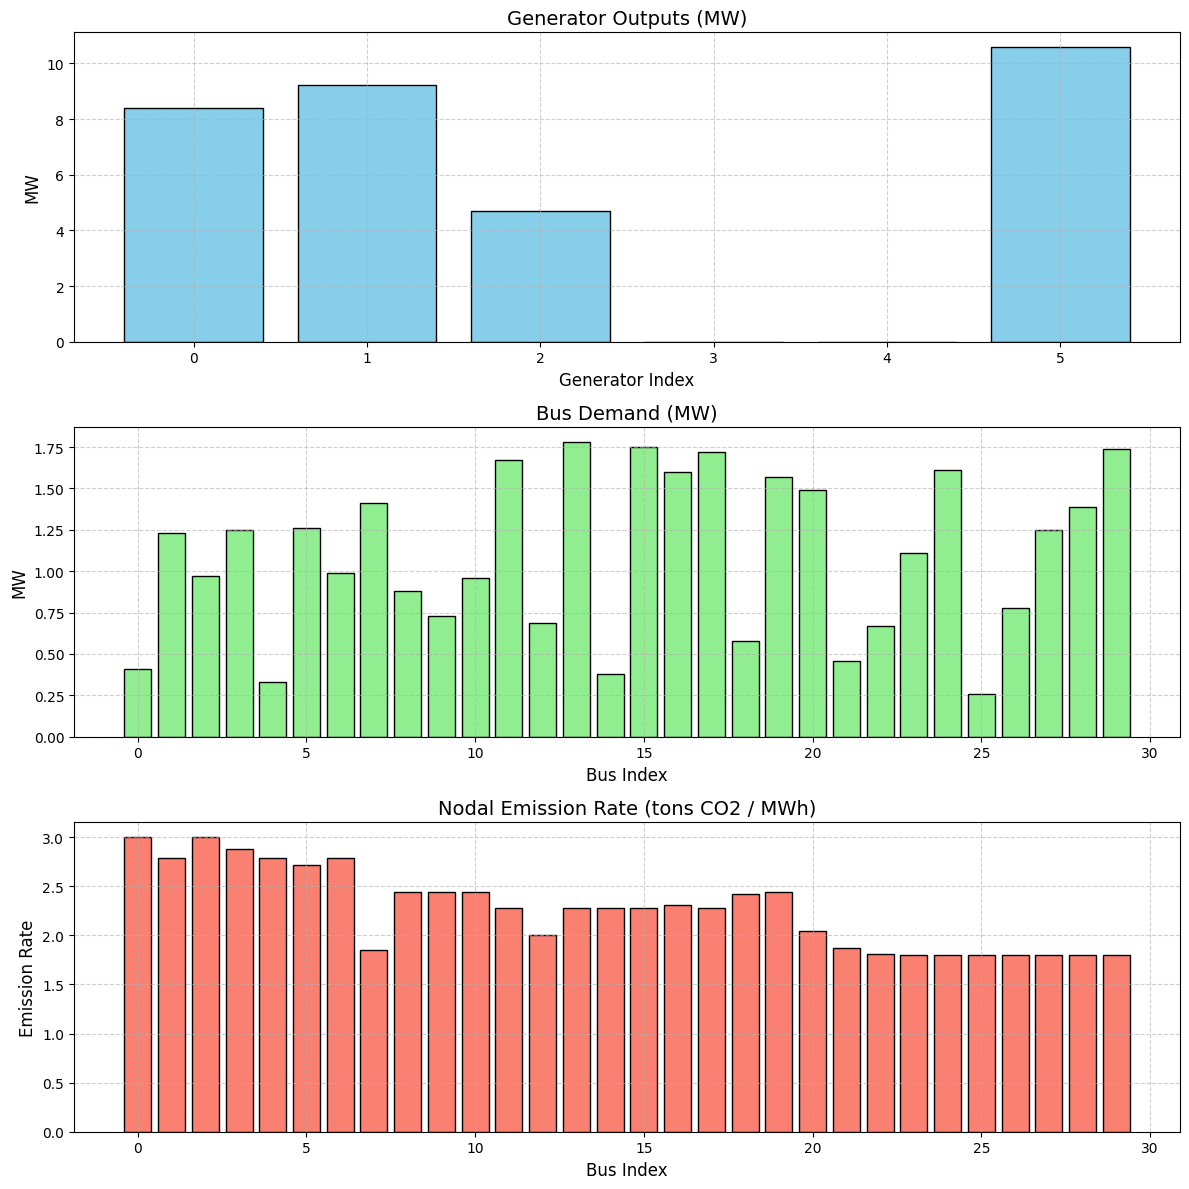

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

# 1. Generator outputs
axs[0].bar(range(num_gen), x.value, color="skyblue", edgecolor="black")
axs[0].set_title("Generator Outputs (MW)", fontsize=14)
axs[0].set_xlabel("Generator Index", fontsize=12)
axs[0].set_ylabel("MW", fontsize=12)
axs[0].grid(True, linestyle="--", alpha=0.6)

# 2. Demand (Load) values
axs[1].bar(range(num_buses), load.reshape(-1,), color="lightgreen", edgecolor="black")
axs[1].set_title("Bus Demand (MW)", fontsize=14)
axs[1].set_xlabel("Bus Index", fontsize=12)
axs[1].set_ylabel("MW", fontsize=12)
axs[1].grid(True, linestyle="--", alpha=0.6)

# 3. Nodal emission rate
axs[2].bar(range(num_buses), average_emission_rate.reshape(-1,), color="salmon", edgecolor="black")
axs[2].set_title("Nodal Emission Rate (tons CO2 / MWh)", fontsize=14)
axs[2].set_xlabel("Bus Index", fontsize=12)
axs[2].set_ylabel("Emission Rate", fontsize=12)
axs[2].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
## Use 24 hours timeseries, visualize 